In [71]:
import itertools
import json
import datetime
import pytz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.externals.joblib import Memory
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

%matplotlib inline
np.random.seed(42)
random.seed(42)

In [31]:
wnl = nltk.wordnet.WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]

In [18]:
analyzer = CountVectorizer().build_analyzer()

def stem_lemma(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if not word.isdigit())

def stem_nolemma(doc):
    return (word for word in analyzer(doc) if not word.isdigit())

In [19]:
class SparseToDenseArray(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, X, *_):
        if hasattr(X, 'toarray'):
            return X.toarray()
        return X

    def fit(self, *_):
        return self

In [21]:
def prase_dataset(file):
    """
    find 'text' of all tweets in a file that either belong to "MA" of "WA"
    """
    MA = ["MA", "Boston", "Massachusetts", "Foxborough", "boston", "massachusetts", "foxborough"]
    WA = ["WA", "Seattle", "Washington", "Kirkland", "seattle", "washington", "kirkland"]
    # extract raw features
    tweet_location = []
    tweet_text = []
    for line in open(path + file, 'r') :
        a = json.loads(line)
        location = a['tweet']['user']['location']
        flg_ma = False; flg_wa = False
        for loc_ma in MA:
            if loc_ma in location: 
                flg_ma = True
                break
        for loc_wa in WA:
            if loc_wa in location: 
                flg_wa = True
                break
        if flg_ma and not flg_wa:
            tweet_location.append('MA')
            tweet_text.append(a['tweet']['text'])
        elif flg_wa and not flg_ma:
            tweet_location.append('WA')
            tweet_text.append(a['tweet']['text'])
            
    return tweet_text, tweet_location

In [39]:
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

def fit_predict_and_plot_roc(pipe, train_data, train_label, test_data, test_label):
    pipe.fit(train_data, train_label)
    # pipeline1.predict(twenty_test.data)

    if hasattr(pipe, 'decision_function'):
        prob_score = pipe.decision_function(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score)
    else:
        prob_score = pipe.predict_proba(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score[:,1])

    plot_roc(fpr, tpr)

In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


## Read the data

In [22]:
path = "./ECE219_tweet_data/"

files = ["tweets_#gohawks.txt", "tweets_#gopatriots.txt", \
        "tweets_#nfl.txt", "tweets_#patriots.txt", \
        "tweets_#sb49.txt", "tweets_#superbowl.txt"]
topics = ["gohawks", "gopatriots", "nfl", "patriots", "sb49", "superbowl"]

for i, fl in enumerate(files):
    print("files[" + str(i) + "] => " + fl)

files[0] => tweets_#gohawks.txt
files[1] => tweets_#gopatriots.txt
files[2] => tweets_#nfl.txt
files[3] => tweets_#patriots.txt
files[4] => tweets_#sb49.txt
files[5] => tweets_#superbowl.txt


In [23]:
All_tweet_location = []
All_tweet_text = []
for f in files:
    text, location = prase_dataset(f)
    All_tweet_location.extend(location)
    All_tweet_text.extend(text)

In [61]:
print("# of tweets for MA = ", All_tweet_location.count('MA'))
print("# of tweets for WA = ", All_tweet_location.count('WA'))
print(All_tweet_location[0])
print('\'MA\' has label 0, \'WA\' has label 1.')
class_names = ['MA', 'WA']

# of tweets for MA =  67978
# of tweets for WA =  119391
WA
'MA' has label 0, 'WA' has label 1.


In [25]:
lb = preprocessing.LabelBinarizer()
X_train, X_test, y_train, y_test = train_test_split(All_tweet_text, lb.fit_transform(All_tweet_location), 
                                                    test_size=0.2, shuffle=True, random_state=42)

In [65]:
print(len(X_test), len(X_train))

37474 149895


## Feature Extraction

In [32]:
vectorizer = CountVectorizer(min_df=3, 
                             analyzer=stem_lemma, 
                             stop_words='english')

# fit_tranform train data
X_train_counts = vectorizer.fit_transform(X_train)
print("train count size ", X_train_counts.shape)


X_test_counts = vectorizer.transform(X_test)
print("test count size ", X_test_counts.shape)


train count size  (149895, 18514)
test count size  (37474, 18514)


In [36]:
tfidf_transformer = TfidfTransformer()

# fit_tranform train data
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# transform test data
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

## Dimensionality Reduction

In [38]:
svd = TruncatedSVD(n_components=50, random_state=42)
X_train_reduced = svd.fit_transform(X_train_tfidf)
print(X_train_reduced.shape)

(149895, 50)


## Train a logistic regression model

In [66]:
pipeline1 = Pipeline([
    ('vect', vectorizer),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=100, random_state=42)),
    ('clf', LogisticRegression(penalty='l2', C=3.3)),
])

/home/zeyudesk/anaconda3/envs/219project5/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/zeyudesk/anaconda3/envs/219project5/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


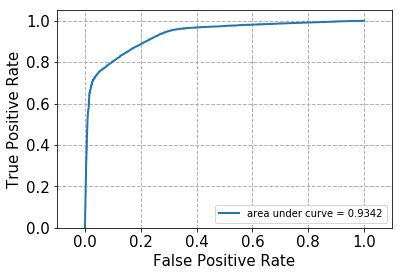

In [67]:
fit_predict_and_plot_roc(pipeline1, X_train, y_train, X_test, y_test)

In [68]:
pred1 = pipeline1.predict(X_test)

In [69]:
print('accuracy:', accuracy_score(y_test, pred1))
print('recall:', recall_score(y_test, pred1))
print('precision:', precision_score(y_test, pred1))
print('f1_score:', f1_score(y_test, pred1))

accuracy: 0.860009606660618
recall: 0.928066284470854
precision: 0.862789340595215
f1_score: 0.89423813555905


Confusion matrix, without normalization
[[10118  3459]
 [ 1894 22003]]
Normalized confusion matrix
[[0.75 0.25]
 [0.08 0.92]]


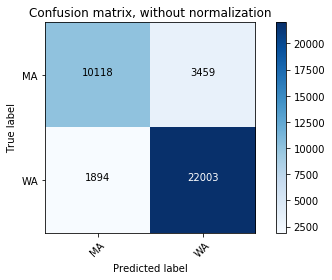

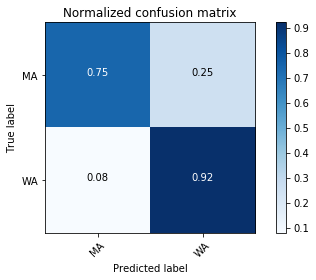

In [53]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred1)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Train a random forest classifier

In [72]:
pipeline2 = Pipeline([
    ('vect', vectorizer),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=100, random_state=42)),
    ('clf', RandomForestClassifier(n_estimators=150, max_features=10)),
])

/home/zeyudesk/anaconda3/envs/219project5/lib/python3.7/site-packages/sklearn/pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


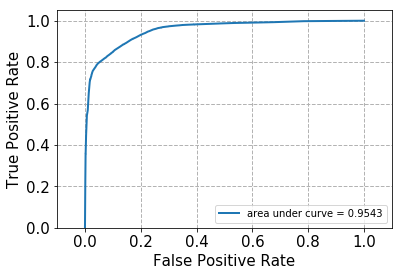

In [73]:
fit_predict_and_plot_roc(pipeline2, X_train, y_train, X_test, y_test)

In [74]:
pred2 = pipeline2.predict(X_test)

In [75]:
print('accuracy:', accuracy_score(y_test, pred2))
print('recall:', recall_score(y_test, pred2))
print('precision:', precision_score(y_test, pred2))
print('f1_score:', f1_score(y_test, pred2))

accuracy: 0.8839195175321556
recall: 0.9404946227559945
precision: 0.8847380230681415
f1_score: 0.9117647058823529


Confusion matrix, without normalization
[[10649  2928]
 [ 1422 22475]]
Normalized confusion matrix
[[0.78 0.22]
 [0.06 0.94]]


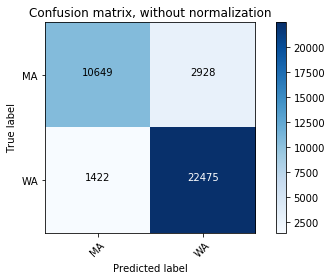

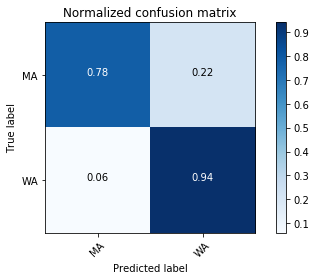

In [76]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Train a Adaboost classifier

In [77]:
pipeline3 = Pipeline([
    ('vect', vectorizer),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=100, random_state=42)),
    ('clf', AdaBoostClassifier(n_estimators=200, learning_rate=0.03, random_state=42)),
])

/home/zeyudesk/anaconda3/envs/219project5/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


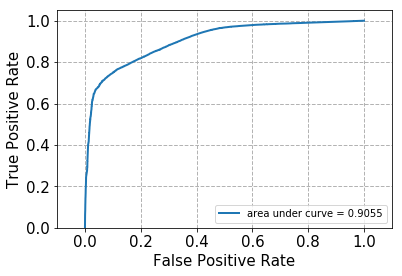

In [78]:
fit_predict_and_plot_roc(pipeline3, X_train, y_train, X_test, y_test)

In [79]:
pred3 = pipeline3.predict(X_test)

In [80]:
print('accuracy:', accuracy_score(y_test, pred3))
print('recall:', recall_score(y_test, pred3))
print('precision:', precision_score(y_test, pred3))
print('f1_score:', f1_score(y_test, pred3))

accuracy: 0.8149917275978011
recall: 0.9130016320040173
precision: 0.818011397720456
f1_score: 0.8629001957721134


Confusion matrix, without normalization
[[ 8723  4854]
 [ 2079 21818]]
Normalized confusion matrix
[[0.64 0.36]
 [0.09 0.91]]


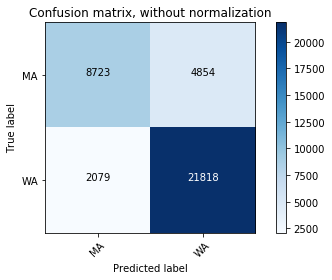

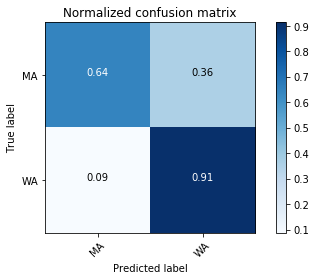

In [81]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred3)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()